<a href="https://colab.research.google.com/github/arminnv/Deep-Learning-Fall-2024/blob/main/HW1/CART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Full Name : Armin Navardi
### Student Number : 99105129


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        # To DO
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
def explore_data(data_loader, title):
    # Get a batch of data
    # TO DO
    for step, (batch, labels) in enumerate(data_loader):
      batch1 = batch
      break
    # TO DO
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
      img = batch1[i].squeeze(0).numpy()
      axes[i].imshow(img, cmap='gray')
      axes[i].axis('off')
    plt.show()
    # TO DO
    labels = []
    for _, label in data_loader:
        labels.append(label.numpy())
    labels = np.concatenate(labels)

    plt.figure(figsize=(8, 6))
    plt.hist(labels, bins=10, range=(0, 9), edgecolor='black', alpha=0.7)
    plt.title(f"Label Distribution - {title}")
    plt.xlabel("Label")
    plt.ylabel("Frequency")
    plt.show()
    plt.suptitle(title)



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.79MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.03MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



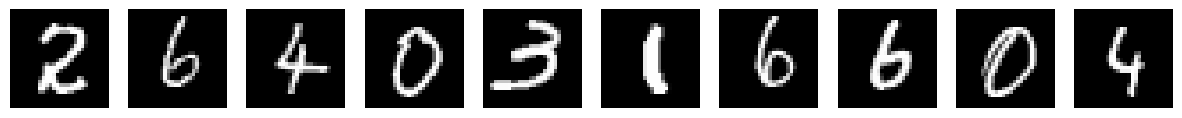

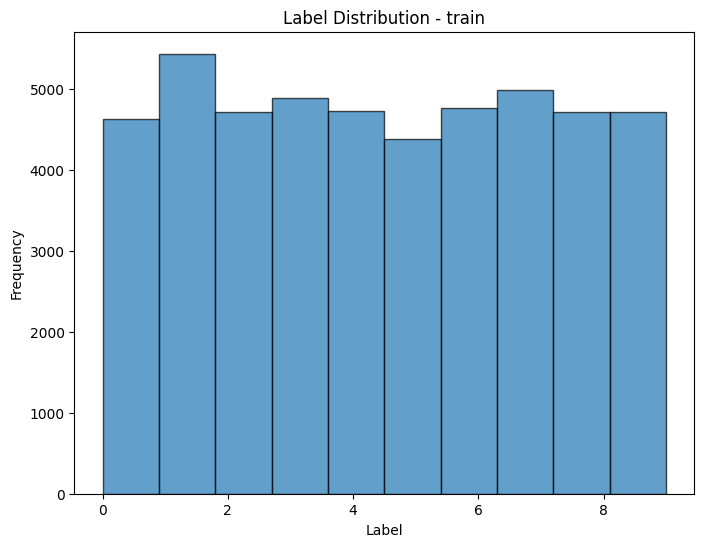

<Figure size 640x480 with 0 Axes>

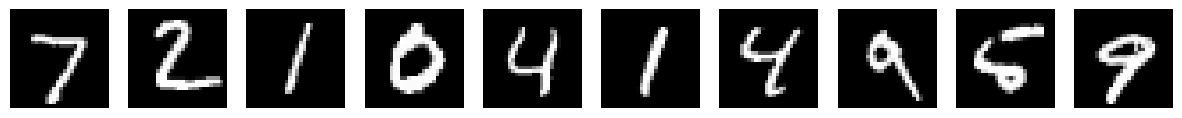

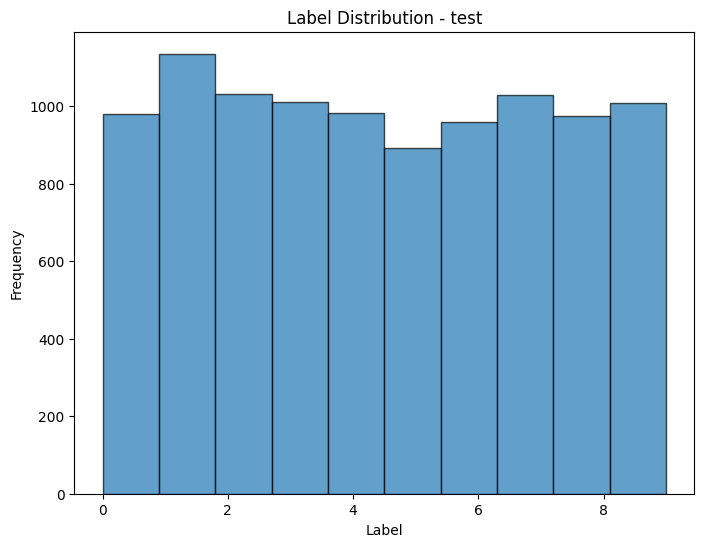

<Figure size 640x480 with 0 Axes>

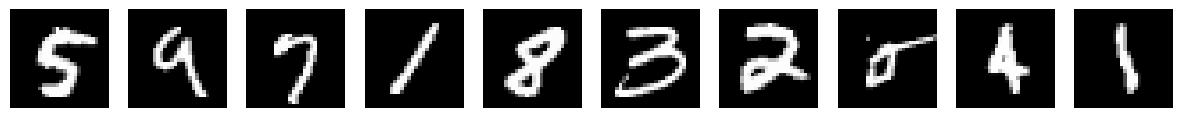

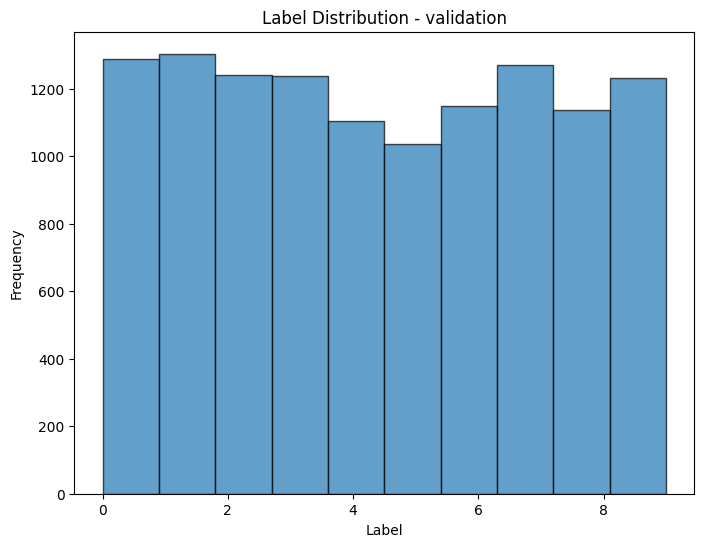

<Figure size 640x480 with 0 Axes>

In [4]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader, 'train')
explore_data(test_loader, 'test')
explore_data(val_loader, 'validation')


Prepare the data for use with the CART algorithm by flattening the images.

In [6]:
def prepare_data_for_cart(data_loader):
    # TO DO
    X = []
    y = []

    for images, labels in data_loader:

        for image in images:
            flattened_image = image.view(-1).numpy()
            X.append(flattened_image)

        y.extend(labels.numpy())

    X = np.array(X)
    y = np.array(y)

    return X, y

In [7]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

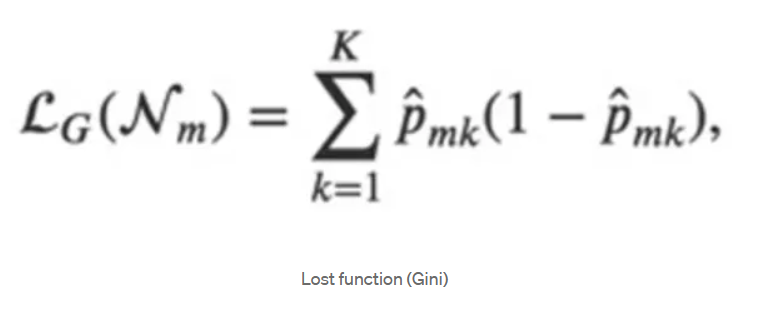

In [8]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape

        if depth >= self.max_depth or num_samples < self.min_samples_split or len(np.unique(y)) == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._find_best_split(X, y)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        best_gini = float("inf")
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gini = self._calculate_gini_for_split(X[:, feature_idx], y, threshold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_for_split(self, feature_column, y, threshold):
        left_idxs, right_idxs = self._split(feature_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return float("inf")

        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        gini_left = self._gini_impurity(y[left_idxs])
        gini_right = self._gini_impurity(y[right_idxs])
        weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right

        return weighted_gini

    def _gini_impurity(self, y):
        m = len(y)
        if m == 0:
            return 0
        label_counts = Counter(y)
        impurity = 1.0
        for count in label_counts.values():
            p = count / m
            impurity -= p ** 2
        return impurity

    def _split(self, feature_column, threshold):
        left_idxs = np.where(feature_column <= threshold)[0]
        right_idxs = np.where(feature_column > threshold)[0]
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

Performance of the models are almost the same for depth < 6, However ours is slightly better than the scikit's.

My CART Accuracy : 0.601
Sklearn CART Accuracy:  0.591


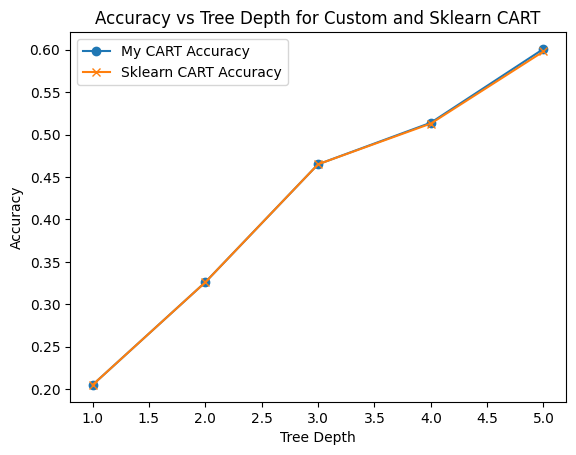

In [16]:
X_train = X_train[:1000] # TO DO
y_train = y_train[:1000] # TO DO

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train, y_train)

X_test = X_test[:1000] # TO DO
y_test = y_test[:1000]

predictions = tree.predict(X_test)
print("My CART Accuracy :", np.mean(predictions==y_test))

# TO DO

sklearn_cart = DecisionTreeClassifier(max_depth=5)
sklearn_cart.fit(X_train, y_train)
sklearn_y_pred = sklearn_cart.predict(X_test)
print("Sklearn CART Accuracy: ", np.mean(sklearn_y_pred==y_test))

depths = range(1, 6)
my_accuracies = []
sklearn_accuracies = []

for depth in depths:
    my_cart = DecisionTree_CART(max_depth=depth)
    my_cart.fit(X_train, y_train)
    my_y_pred = my_cart.predict(X_test)
    my_accuracies.append(accuracy_score(y_test, my_y_pred))

    sklearn_cart = DecisionTreeClassifier(max_depth=depth, random_state=42)
    sklearn_cart.fit(X_train, y_train)
    sklearn_y_pred = sklearn_cart.predict(X_test)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_y_pred))

plt.plot(depths, my_accuracies, label="My CART Accuracy", marker='o')
plt.plot(depths, sklearn_accuracies, label="Sklearn CART Accuracy", marker='x')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth for Custom and Sklearn CART")
plt.legend()
plt.show()


## Question
What is the difference between ID3 and CART algorithm


Splitting Criterion:
ID3 uses Information Gain as the splitting criterion while CART uses Gini Impurity for classification tasks, and Mean Squared Error for regression tasks which makes it suitable for both categorical and continuous data types

Split Numbers:
ID3 can produce multiway splits but CART creates binary splits only.

Supported Data Types:
ID3 is limited to classification trees and does not support regression. CART supports both classification and regression trees.